<center>
    <h1><b>Data-Mining Techniques Assignment</b></h1>
</center>

This notebook is part of a university course assignment **'Data-Mining Techniques'**. This project involves e-commerce analysis using the **Amazon Product Dataset**. The project is devided into two parts:
1. Data Exploration & feature engineering, and
2. machine learning tasks including clustering, classification, recommendation system, and sentiment analysis.

The members of this assignment are shown in the following table

<div align="center">

| Ονοματεπώνυμο    | Αριθμός Μητρώου  |        email         |
| :-------------:  | :-------------:  |   :-------------:    |
| Ζήκας Αντώνιος   | 1115202100038    | sdi2100038@di.uoa.gr |
| Κώτσιλας Σταύρος | 1115201700292    | sdi1700292@di.uoa.gr |

</div>

# Notebook Settings

## Number of records to work
Here we define a constant that describes how many records for each category will be downloaded

**Set it to `-1` to download all the available records**

In [2]:
RECORDS_COUNT = 1000 # -1 to download all records

## Plotting theme
Firstly we will initialize the plotting theme of the graphs. This is an optional and can be be skipped

In [3]:
import matplotlib.pyplot as plt

theme = 'light' # You can adjust the theme here, options are 'dark' or 'light'
if theme == 'dark':
    plt.style.use('dark_background')
else:
    plt.style.use('default')

# Part 1: Data Pre-processing
In the first part we will explore the datasets we are going to use and do some pre-processing and analysis on them. We chose to work with the following categories:
1. `All_Beauty`
2. `Digital_Music`
3. `Gift_Cards`
4. `Magazine_Subscriptions`
5. `Video_Games`

## Task 1: Data Exploration and Feature Engineering
### 1. Data Preperation
In this section we will extract our datafor the five categories above. We will download the JSON files and we will parse them in order to create the CSV files that we are going to use for the rest of the tasks.

#### Downloading the datasets
We are going to define a function that will download the datasets for us. Here we are going to use `streamming=True` so we don't download the entire dataset at once, but we will be able to access its contents. This is done for experimenting purposes.

In [4]:
from datasets import load_dataset

def download_datasets(categories, data_type="review"):
    ''' Downloads the specified type of datasets (review or meta) for the given categories. '''
    
    if data_type not in ["review", "meta"]:
        raise ValueError("Invalid data_type. Choose either 'review' or 'meta'.")
    
    # Loop through the categories and download the datasets
    # using the load_dataset function from the datasets library
    datasets = []
    for category in categories:
        print(f"Downloading {data_type} dataset for category: {category}")
        dataset = load_dataset(
            "McAuley-Lab/Amazon-Reviews-2023",
            f"raw_{data_type}_{category}",
            trust_remote_code=True,
            streaming=True
        )
        datasets.append(dataset)
    
    return datasets

/opt/anaconda3/envs/Data-Mining-venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's download the datasets for the five categories specified above. We will download both **reviews** and **meta** data for the categories.

In [5]:
# Define the categories to download (can be modified as needed)
categories = ["All_Beauty", "Digital_Music", "Gift_Cards", "Magazine_Subscriptions", "Video_Games"]

# Download the review and meta data for the specified categories
review_datasets = download_datasets(categories, data_type="review")
meta_datasets = download_datasets(categories, data_type="meta")

print("\nDatasets downloaded successfully.")


Datasets downloaded successfully.


#### Creation of CSV files
Finally let's create the corresponding **CSV files** for the datasets and save them locally to use them later. We will also define a function that will handle this for us.

In [6]:
import pandas as pd
import os

def construct_csv_files(categories, datasets, max_records=100, output_dir="output"):
    ''' Constructs dictionaries for each category from the review or meta datasets and saves them as CSV files. '''
    os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists
    
    categories_dictionaries = {}
    for category, dataset in zip(categories, datasets):
        csv_path = os.path.join(output_dir, f"{category}_data.csv")
        
        # Check if the CSV file already exists
        if os.path.exists(csv_path):
            print(f" - CSV file for category '{category}' already exists at: {csv_path}. Skipping creation.")
            continue
        
        for i, record in enumerate(dataset['full']):
            if i == 0:
                dictionary = {key: [] for key in record.keys()}
            for key in record.keys():
                dictionary[key].append(record[key])
            if i == max_records - 1:
                break
        
        # Save the dictionary as a CSV file
        df = pd.DataFrame(dictionary)
        df.to_csv(csv_path, index=False)
        print(f" - CSV file created for category '{category}' at: {csv_path} ({len(df)} records)")
        
        categories_dictionaries[category] = dictionary
    
    return categories_dictionaries

In [7]:
data_path = "../data/raw" # Path to save the CSV files

print("\nConstructing CSV files for review datasets...")
review_dictionaries = construct_csv_files(categories, review_datasets, max_records=RECORDS_COUNT, output_dir=f"{data_path}/review")

print("\nConstructing CSV files for meta datasets...")
meta_dictionaries = construct_csv_files(categories, meta_datasets, max_records=RECORDS_COUNT, output_dir=f"{data_path}/meta")


Constructing CSV files for review datasets...
 - CSV file for category 'All_Beauty' already exists at: ../data/raw/review/All_Beauty_data.csv. Skipping creation.
 - CSV file for category 'Digital_Music' already exists at: ../data/raw/review/Digital_Music_data.csv. Skipping creation.
 - CSV file for category 'Gift_Cards' already exists at: ../data/raw/review/Gift_Cards_data.csv. Skipping creation.
 - CSV file for category 'Magazine_Subscriptions' already exists at: ../data/raw/review/Magazine_Subscriptions_data.csv. Skipping creation.
 - CSV file for category 'Video_Games' already exists at: ../data/raw/review/Video_Games_data.csv. Skipping creation.

Constructing CSV files for meta datasets...
 - CSV file for category 'All_Beauty' already exists at: ../data/raw/meta/All_Beauty_data.csv. Skipping creation.
 - CSV file for category 'Digital_Music' already exists at: ../data/raw/meta/Digital_Music_data.csv. Skipping creation.
 - CSV file for category 'Gift_Cards' already exists at: ../da

#### Loading the CSV files to Pandas Dataframes
Next we will pre-process and clean our data. We start by loading the loading the CSV files we just saved to **Pandas Dataframes**. This will let us work more conviniently. Let's create a function for that and load the dataframes.

In [8]:
def load_csv_files(categories, data_path="../data"):
    ''' Loads the CSV files for the specified categories into pandas dataframes. '''
    
    # Initialize a dictionary to hold the dataframes
    dataframes = {'review': {}, 'meta': {}}
    
    # Loop through the categories and load the CSV files into dataframes
    for mode in ['review', 'meta']:
        for category in categories:
            csv_path = os.path.join(data_path, mode, f"{category}_data.csv")
            if os.path.exists(csv_path):
                dataframes[mode][category] = pd.read_csv(csv_path)
                print(f" - Loaded {mode} data for category '{category}' from: {csv_path}")
            else:
                print(f" - CSV file for category '{category}' not found at: {csv_path}. Skipping loading.")
    
    return dataframes

In [9]:
dataframes = load_csv_files(categories, data_path=data_path)

 - Loaded review data for category 'All_Beauty' from: ../data/raw/review/All_Beauty_data.csv
 - Loaded review data for category 'Digital_Music' from: ../data/raw/review/Digital_Music_data.csv
 - Loaded review data for category 'Gift_Cards' from: ../data/raw/review/Gift_Cards_data.csv
 - Loaded review data for category 'Magazine_Subscriptions' from: ../data/raw/review/Magazine_Subscriptions_data.csv
 - Loaded review data for category 'Video_Games' from: ../data/raw/review/Video_Games_data.csv
 - Loaded meta data for category 'All_Beauty' from: ../data/raw/meta/All_Beauty_data.csv
 - Loaded meta data for category 'Digital_Music' from: ../data/raw/meta/Digital_Music_data.csv
 - Loaded meta data for category 'Gift_Cards' from: ../data/raw/meta/Gift_Cards_data.csv
 - Loaded meta data for category 'Magazine_Subscriptions' from: ../data/raw/meta/Magazine_Subscriptions_data.csv
 - Loaded meta data for category 'Video_Games' from: ../data/raw/meta/Video_Games_data.csv


#### Dataframes Visualization
Let's have a look at the **review** and **meta** data for the first category: **All_Beauty**

In [10]:
all_beauty_review_df = dataframes['review']['All_Beauty']
all_beauty_meta_df = dataframes['meta']['All_Beauty']

In [11]:
all_beauty_review_df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True
3,1.0,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1643393630220,0,True
4,5.0,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1609322563534,0,True


In [12]:
all_beauty_meta_df.head()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
0,All Beauty,"Howard LC0008 Leather Conditioner, 8-Ounce (4-...",4.8,10,[],[],NaN,"{'hi_res': [None, 'https://m.media-amazon.com/...","{'title': [], 'url': [], 'user_id': []}",Howard Products,[],"{""Package Dimensions"": ""7.1 x 5.5 x 3 inches; ...",B01CUPMQZE,NaN,NaN,NaN
1,All Beauty,Yes to Tomatoes Detoxifying Charcoal Cleanser ...,4.5,3,[],[],NaN,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",Yes To,[],"{""Item Form"": ""Powder"", ""Skin Type"": ""Acne Pro...",B076WQZGPM,NaN,NaN,NaN
2,All Beauty,Eye Patch Black Adult with Tie Band (6 Per Pack),4.4,26,[],[],NaN,"{'hi_res': [None, None], 'large': ['https://m....","{'title': [], 'url': [], 'user_id': []}",Levine Health Products,[],"{""Manufacturer"": ""Levine Health Products""}",B000B658RI,NaN,NaN,NaN
3,All Beauty,"Tattoo Eyebrow Stickers, Waterproof Eyebrow, 4...",3.1,102,[],[],NaN,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",Cherioll,[],"{""Brand"": ""Cherioll"", ""Item Form"": ""Powder"", ""...",B088FKY3VD,NaN,NaN,NaN
4,All Beauty,Precision Plunger Bars for Cartridge Grips – 9...,4.3,7,"['Material: 304 Stainless Steel; Brass tip', '...",['The Precision Plunger Bars are designed to w...,NaN,"{'hi_res': [None], 'large': ['https://m.media-...","{'title': [], 'url': [], 'user_id': []}",Precision,[],"{""UPC"": ""644287689178""}",B07NGFDN6G,NaN,NaN,NaN


#### Data Cleaning
Now that we have our data loaded into pandas dataframe, we can start **pre-processing** them. The **Data Cleaning** that we are going to apply consists of three tasks:
1. Handle missing values,
2. Normalize prices, and
3. Pre-process text

##### i) Handle Missing Values
We start the cleaning procedure by **handling missing values**. We will start by identifying which columns of the datasets have missing values.

In [13]:
# First search in the review dataframes
for category in categories:
    dataframe = dataframes['review'][category]
    missing_summary = dataframe.isnull().sum()
    print(f"Missing summary in {category} review data:\n{missing_summary[missing_summary > 0]}")

Missing summary in All_Beauty review data:
Series([], dtype: int64)
Missing summary in Digital_Music review data:
Series([], dtype: int64)
Missing summary in Gift_Cards review data:
Series([], dtype: int64)
Missing summary in Magazine_Subscriptions review data:
Series([], dtype: int64)
Missing summary in Video_Games review data:
Series([], dtype: int64)


In [14]:
# Next, search in the meta dataframes
for category in categories:
    dataframe = dataframes['meta'][category]
    missing_summary = dataframe.isnull().sum()
    print(f"Missing summary in {category} meta data:\n{missing_summary[missing_summary > 0]}")

Missing summary in All_Beauty meta data:
price               799
store                99
bought_together    1000
subtitle           1000
author             1000
dtype: int64
Missing summary in Digital_Music meta data:
price               390
store                61
bought_together    1000
subtitle           1000
author             1000
dtype: int64
Missing summary in Gift_Cards meta data:
main_category       117
price               641
store                15
bought_together    1000
subtitle           1000
author             1000
dtype: int64
Missing summary in Magazine_Subscriptions meta data:
price              1000
store                53
bought_together    1000
subtitle           1000
author             1000
dtype: int64
Missing summary in Video_Games meta data:
main_category         4
price               466
store                25
bought_together    1000
subtitle           1000
author             1000
dtype: int64


As we see the missing values we are dealing with are refering to the **meta** data of the datasets. The review datasets seems to not have any missing value. As for the meta datasets, it seems to have empty values at columns: **main_category, price, store, bought_together, subtitle, and author**. We are going to deal with these missing values as follows:
- `main_category` $\rightarrow$ fill with the most common value from the other rows
- `price` $\rightarrow$ fill with 0.0
- `store` $\rightarrow$ fill with ''
- `bought_together` $\rightarrow$ fill with empty list []
- `subtitle` $\rightarrow$ fill with ''
- `author` $\rightarrow$ fill with ''

Let's define a function that will handle missing values for a dataframe, using the above sceptic

In [15]:
def handle_missing_values(dataframe):
    ''' Handles missing values in a given dataframe. '''
    
    # Fill 'main_category' with the most common value of the column
    dataframe['main_category'] = dataframe['main_category'].fillna(dataframe['main_category'].mode()[0])

    # Fill 'price' with the 0.0 value
    dataframe['price'] = dataframe['price'].fillna(0.0)

    # Fill 'store' with empty string
    dataframe['store'] = dataframe['store'].fillna("")

    # Fill 'bought_together' with empty list
    dataframe['bought_together'] = dataframe['bought_together'].fillna("[]")

    # Fill 'title' with empty string
    dataframe['title'] = dataframe['title'].fillna("")

    # Fill 'subtitle' with empty strings
    dataframe['subtitle'] = dataframe['subtitle'].fillna("")

    # Fill 'author' with empty string
    dataframe['author'] = dataframe['author'].fillna("")

    return dataframe

Let's apply the above function to all meta dataframes

In [16]:
# Handle missing values for all the meta dataframes
for dataframe in dataframes['meta'].values():
    dataframe = handle_missing_values(dataframe)
    dataframes['meta'][category] = dataframe

And finally let's see the results

In [17]:
# Next, search in the meta dataframes
for category in categories:
    dataframe = dataframes['meta'][category]
    missing_summary = dataframe.isnull().sum()
    print(f"Missing summary in {category} meta data:\n{missing_summary[missing_summary > 0]}")

Missing summary in All_Beauty meta data:
Series([], dtype: int64)
Missing summary in Digital_Music meta data:
Series([], dtype: int64)
Missing summary in Gift_Cards meta data:
Series([], dtype: int64)
Missing summary in Magazine_Subscriptions meta data:
Series([], dtype: int64)
Missing summary in Video_Games meta data:
Series([], dtype: int64)


As we see all the missing values have been removed with the previous logic, and we can continue with normalizing prices.

##### ii) Normalizing prices
Next we will normalize the prices of the meta dataframes. There are many ways of normalizing numeric values. Some of them are:
- Min-Max normalization (Scaling to 0 - 1)
- Standardization (Z-score Normalization)
- Log Normalization
- Currency Normalization (less common)

In this notebook we will use **Min-Max normalization (Scaling to 0 - 1)**. Let's define a function for that.

In [18]:
def normalize_prices(dataframe):
    ''' 
    Normalizes the prices in a given dataframe, using min-max normalization (scaling to [0, 1]),
    and creating a new column 'normalized_price' to store the normalized values'.
    '''
    # Ensure the 'price' column is numeric
    dataframe['price'] = dataframe['price'].replace('—', 0.0)
    dataframe['price'] = pd.to_numeric(dataframe['price'])
    min_price, max_price = dataframe['price'].min(), dataframe['price'].max()
    if min_price == max_price:
        dataframe['normalized_price'] = 0.0
    else:
        dataframe['normalized_price'] = (dataframe['price'] - min_price) / (max_price - min_price)
        
    return dataframe

Let's apply this function to the meta data.

In [19]:
for category in categories:
    dataframe = dataframes['meta'][category]
    dataframe = normalize_prices(dataframe)
    dataframes['meta'][category] = dataframe
    print(f" - Normalized prices for category '{category}'")

 - Normalized prices for category 'All_Beauty'
 - Normalized prices for category 'Digital_Music'
 - Normalized prices for category 'Gift_Cards'
 - Normalized prices for category 'Magazine_Subscriptions'
 - Normalized prices for category 'Video_Games'


Let's have a look at the meta data of the 'All Beauty' category and check what is the **maximum** and **minimum** price in each dataset related to their normalized values.

In [20]:
dataframes['meta']['All_Beauty'].head()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author,normalized_price
0,All Beauty,"Howard LC0008 Leather Conditioner, 8-Ounce (4-...",4.8,10,[],[],0.0,"{'hi_res': [None, 'https://m.media-amazon.com/...","{'title': [], 'url': [], 'user_id': []}",Howard Products,[],"{""Package Dimensions"": ""7.1 x 5.5 x 3 inches; ...",B01CUPMQZE,[],,,0.0
1,All Beauty,Yes to Tomatoes Detoxifying Charcoal Cleanser ...,4.5,3,[],[],0.0,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",Yes To,[],"{""Item Form"": ""Powder"", ""Skin Type"": ""Acne Pro...",B076WQZGPM,[],,,0.0
2,All Beauty,Eye Patch Black Adult with Tie Band (6 Per Pack),4.4,26,[],[],0.0,"{'hi_res': [None, None], 'large': ['https://m....","{'title': [], 'url': [], 'user_id': []}",Levine Health Products,[],"{""Manufacturer"": ""Levine Health Products""}",B000B658RI,[],,,0.0
3,All Beauty,"Tattoo Eyebrow Stickers, Waterproof Eyebrow, 4...",3.1,102,[],[],0.0,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",Cherioll,[],"{""Brand"": ""Cherioll"", ""Item Form"": ""Powder"", ""...",B088FKY3VD,[],,,0.0
4,All Beauty,Precision Plunger Bars for Cartridge Grips – 9...,4.3,7,"['Material: 304 Stainless Steel; Brass tip', '...",['The Precision Plunger Bars are designed to w...,0.0,"{'hi_res': [None], 'large': ['https://m.media-...","{'title': [], 'url': [], 'user_id': []}",Precision,[],"{""UPC"": ""644287689178""}",B07NGFDN6G,[],,,0.0


In [21]:
for category in categories:
    print(f"{category}: Max price: {dataframes['meta'][category]['price'].max()}", end=", ")
    print(f"Min price: {dataframes['meta'][category]['price'].min()}", end=", ")
    print(f"Normalized max price: {dataframes['meta'][category]['normalized_price'].max()}", end=", ")
    print(f"Normalized min price: {dataframes['meta'][category]['normalized_price'].min()}")

All_Beauty: Max price: 179.95, Min price: 0.0, Normalized max price: 1.0, Normalized min price: 0.0
Digital_Music: Max price: 911.08, Min price: 0.0, Normalized max price: 1.0, Normalized min price: 0.0
Gift_Cards: Max price: 2000.0, Min price: 0.0, Normalized max price: 1.0, Normalized min price: 0.0
Magazine_Subscriptions: Max price: 0.0, Min price: 0.0, Normalized max price: 0.0, Normalized min price: 0.0
Video_Games: Max price: 0.0, Min price: 0.0, Normalized max price: 0.0, Normalized min price: 0.0


As we see the prices have been normalized successfully. We can continue with the text preprocessing.

##### iii) Pre-processing text
We will now begin the text pre-processing of the data. Fistly we will decide witch columns need to be processed. As we saw in the dataframes representations there are two columns in the review data that contain text. These are **`title`** and **`text`**, while in the meta data only the **`title`** column contain text. So we are going to apply text pre-processing as follows:
- For the review data $\rightarrow$ columns `title` and `text`
- For the meta data $\rightarrow$ column `title`

The next step is to determine what **pre-processing techniques** will be used. We have decided to apply the following rules on the pre-processing:
1. **Lowercase** text,
2. Remove **punctuation**,
3. **Stemming** and **Lemmatization** of words,
4. Remove **URLS** (https://...), **user mentions** (@user123) and **hashtags** (#hashtag_example), and
5. Remove **stop-words**

We will create a function that will apply the above rules to a single string variable. First we will make sure all the appropriate packages are installed in our system.

In [22]:
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/antonis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/antonis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/antonis/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/antonis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

And then we will define our function

In [23]:
import re

def preprocess_text(text):
    ''' 
    Preprocesses the text by removing special characters, converting to lowercase, 
    and removing stop-words. 
    '''
    if not isinstance(text, str):
        return ''
    
    # 1. Lowercase the text and remove punctuation
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)

    # 2. Apply stemming or lemmatization to words
    stemmer = nltk.stem.PorterStemmer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [stemmer.stem(token) for token in tokens]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    text = ' '.join(tokens)

    # 3. Remove URLs, user mentions, and hashtags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'#\S+', '', text)

    # 4. Remove stop-words
    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]

    return ' '.join(tokens)

Let's apply the cleaning function to the columns mentioned above

In [24]:
import time

output_file_path = "../data/processed/"
if os.path.exists(output_file_path):
    print(f"Data are already processed and stored in {output_file_path}.")
    dataframes = load_csv_files(categories, data_path=output_file_path)
else:
    print("Pre-processing started")
    os.makedirs(output_file_path)
    t0 = time.time()

    print(" - Preprocessing review data...")
    os.makedirs(f"{output_file_path}/review", exist_ok=True)
    for category, dataframe in dataframes['review'].items():
        print(f"  * Preprocessing {category} review data...")
        dataframe['cleaned_title'] = dataframe['title'].apply(preprocess_text)
        dataframe['cleaned_text'] = dataframe['text'].apply(preprocess_text)
        dataframe.to_csv(f"{output_file_path}/review/{category}_data.csv", index=False)

    print(" - Preprocessing meta data...")
    os.makedirs(f"{output_file_path}/meta", exist_ok=True)
    for category, dataframe in dataframes['meta'].items():
        print(f"  *  Preprocessing {category} meta data...")
        dataframe['cleaned_title'] = dataframe['title'].apply(preprocess_text)
        dataframe.to_csv(f"{output_file_path}/meta/{category}_data.csv", index=False)

    print(f"\nPreprocessing completed in {time.time() - t0:.2f} seconds")

Data are already processed and stored in ../data/processed/.
 - Loaded review data for category 'All_Beauty' from: ../data/processed/review/All_Beauty_data.csv
 - Loaded review data for category 'Digital_Music' from: ../data/processed/review/Digital_Music_data.csv
 - Loaded review data for category 'Gift_Cards' from: ../data/processed/review/Gift_Cards_data.csv
 - Loaded review data for category 'Magazine_Subscriptions' from: ../data/processed/review/Magazine_Subscriptions_data.csv
 - Loaded review data for category 'Video_Games' from: ../data/processed/review/Video_Games_data.csv
 - Loaded meta data for category 'All_Beauty' from: ../data/processed/meta/All_Beauty_data.csv
 - Loaded meta data for category 'Digital_Music' from: ../data/processed/meta/Digital_Music_data.csv
 - Loaded meta data for category 'Gift_Cards' from: ../data/processed/meta/Gift_Cards_data.csv
 - Loaded meta data for category 'Magazine_Subscriptions' from: ../data/processed/meta/Magazine_Subscriptions_data.csv
 -

Let's take a look at the pre-processed data.

In [25]:
dataframes['review']['All_Beauty'].head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,cleaned_title,cleaned_text
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True,love scent overpow,thi spray realli nice smell realli good goe re...
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True,work great smell littl weird,thi product doe need wish wa odorless soft coc...
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True,ye,smell good feel great
3,1.0,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1643393630220,0,True,synthet feel,felt synthet
4,5.0,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1609322563534,0,True,NaN,love


In [26]:
dataframes['meta']['All_Beauty'].head()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author,normalized_price,cleaned_title
0,All Beauty,"Howard LC0008 Leather Conditioner, 8-Ounce (4-...",4.8,10,[],[],0.0,"{'hi_res': [None, 'https://m.media-amazon.com/...","{'title': [], 'url': [], 'user_id': []}",Howard Products,[],"{""Package Dimensions"": ""7.1 x 5.5 x 3 inches; ...",B01CUPMQZE,[],NaN,NaN,0.0,howard lc0008 leather condition 8ounc 4pack
1,All Beauty,Yes to Tomatoes Detoxifying Charcoal Cleanser ...,4.5,3,[],[],0.0,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",Yes To,[],"{""Item Form"": ""Powder"", ""Skin Type"": ""Acne Pro...",B076WQZGPM,[],NaN,NaN,0.0,ye tomato detoxifi charcoal cleanser pack 2 ch...
2,All Beauty,Eye Patch Black Adult with Tie Band (6 Per Pack),4.4,26,[],[],0.0,"{'hi_res': [None, None], 'large': ['https://m....","{'title': [], 'url': [], 'user_id': []}",Levine Health Products,[],"{""Manufacturer"": ""Levine Health Products""}",B000B658RI,[],NaN,NaN,0.0,eye patch black adult tie band 6 per pack
3,All Beauty,"Tattoo Eyebrow Stickers, Waterproof Eyebrow, 4...",3.1,102,[],[],0.0,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",Cherioll,[],"{""Brand"": ""Cherioll"", ""Item Form"": ""Powder"", ""...",B088FKY3VD,[],NaN,NaN,0.0,tattoo eyebrow sticker waterproof eyebrow 4d i...
4,All Beauty,Precision Plunger Bars for Cartridge Grips – 9...,4.3,7,"['Material: 304 Stainless Steel; Brass tip', '...",['The Precision Plunger Bars are designed to w...,0.0,"{'hi_res': [None], 'large': ['https://m.media-...","{'title': [], 'url': [], 'user_id': []}",Precision,[],"{""UPC"": ""644287689178""}",B07NGFDN6G,[],NaN,NaN,0.0,precis plunger bar cartridg grip 93mm bag 10 p...


### 2. Ratings and Reviews
In this section we will perform some **Exploratory Data Analysis** (EDA) by creating and showing several plots that describe the behaviour of the data according to different tasks. 

#### 2.1 Product Ratings
The first task is to find the distribution between product ratings within each of the 5 categories we have selected. For this task we use `seaborn`, a very popular library for plotting, and creates **5 plots**, one for each category showing the distribution between user ratings for defferent products of a specific category.  

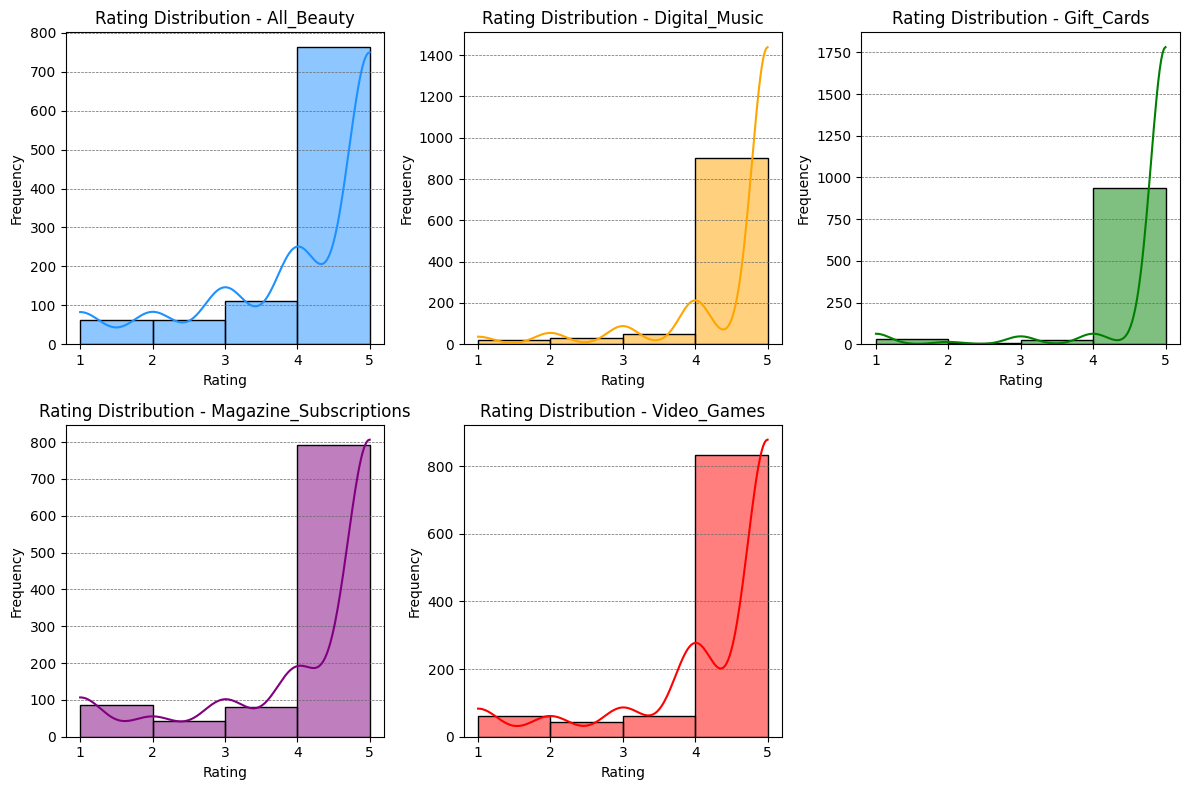

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a histogram for the rating distribution of each category
colors = ['dodgerblue', 'orange', 'green', 'purple', 'red']
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

# Plot the rating distribution for each category
for i, category in enumerate(categories):
    sns.histplot(dataframes['review'][category]['rating'], bins=4, kde=True, ax=axes[i], color=colors[i], stat='frequency')
    axes[i].set_title(f"Rating Distribution - {category}")
    axes[i].set_xlabel("Rating")
    axes[i].set_ylabel("Frequency")
    axes[i].grid(axis='y', color='dimgray', linestyle='dashed', linewidth=0.5)

# Hide any unused subplot axes
for j in range(len(categories), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


As we can see from the above graphs, the **most frequent rating** for each category is **5** and the second one is **1** which makes sence. Finally let's create a bar plot showing the average rating for every category.

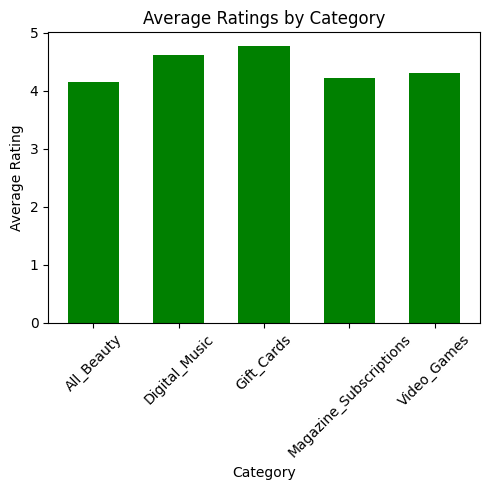

In [28]:
# Get the average rating for each category
average_ratings = {}
for category in categories:
    average_rating = dataframes['review'][category]['rating'].mean()
    average_ratings[category] = average_rating

# Plot the average ratings
plt.figure(figsize=(5, 5))
plt.bar(average_ratings.keys(), average_ratings.values(), color='green', width=0.6)
plt.xlabel("Category")
plt.ylabel("Average Rating")
plt.title("Average Ratings by Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In the above graph we can see that the `Gift_Cards` category has larger average rating than the other 4 categories. The `Digital_music` seems to have almost the same rating as `Gift_Cards`, but `All_Beauty` is having the lowest average rating of all the categories.

#### 2.2 Many Reviews but Low Ratings
Next we will identify the products with **high number of reviews**, but **low ratings**. Specifically we define the following rules:
- **High Reviews Products** are those with `number_of_reviews` being higher than the 75% of the maximum reviews
- **Low Rating** is considered to be lower than `2.5`

First we will create a function that will calculate and return the products with high number of reviews but low ratings for every category.

In [29]:
def get_high_reviews_low_ratings_products(dataframes, categories, high_review_threshold=0.75, low_rating_threshold=2.5):
    """
    Identifies products with high reviews and low ratings.
    """
    high_reviews_low_ratings_products = []

    # Iterate through each category to find products with high reviews and low ratings
    for category in categories:
        products_reviews = {product_id: [] for product_id in dataframes['review'][category]['asin']}

        # Populate the products_reviews dictionary with reviews, ratings, and product IDs
        for _, row in dataframes['review'][category].iterrows():
            rating, review, product_id = row['rating'], str(row['cleaned_text']), row['asin']
            products_reviews[product_id].append((rating, review))

        # Filter products with high reviews and low ratings, and store them in the list
        for product_id, value in products_reviews.items():
            if len(value) >= high_review_threshold:  # Only consider products with high reviews
                average_rating = sum(rating for rating, _ in value) / len(value)
                if average_rating <= low_rating_threshold:
                    high_reviews_low_ratings_products.append({
                        'category': category,
                        'product_id': product_id,
                        'average_rating': average_rating,
                        'reviews': value
                    })

    return high_reviews_low_ratings_products

Next we will construct a function that will return the most common keywords from the products.

In [30]:
def get_common_keywords(high_reviews_low_ratings_products):
    """
    Extracts and counts common keywords from reviews of products with high reviews and low ratings.
    """
    common_keywords = {}

    # Iterate through the products with high reviews and low ratings, and count keywords
    for product in high_reviews_low_ratings_products:
        reviews = product['reviews']
        for _, review in reviews:
            words = review.split()
            for word in words:
                if word not in common_keywords:
                    common_keywords[word] = 0
                common_keywords[word] += 1

    # Sort the keywords by frequency and return the top common keywords
    common_keywords = dict(sorted(common_keywords.items(), key=lambda item: item[1], reverse=True))
    
    return common_keywords

Let's test these functions and get the product of this type. We remind you that products with high number of reviews are meant to be those with 1000 and more reviews and ratings that are smaller than 2.5 are considered to be low ratings.

In [31]:
HIGH_REVIEW_THRESHOLD = 1000  # Threshold for high reviews (1000 or more)
LOW_RATING_THRESHOLD = 2.5  # Threshold for low ratings (2.5 or below)

# Get the products with high reviews and low ratings
high_reviews_low_ratings_products = get_high_reviews_low_ratings_products(dataframes, categories, HIGH_REVIEW_THRESHOLD, LOW_RATING_THRESHOLD)
common_keywords = get_common_keywords(high_reviews_low_ratings_products)

Let's have a look at the products received and plot the most common keywords of these products.

In [32]:
print(f"Number of products with high reviews and low ratings: {len(high_reviews_low_ratings_products)}")
high_reviews_low_ratings_df = pd.DataFrame({
    'category': [product['category'] for product in high_reviews_low_ratings_products],
    'product_id': [product['product_id'] for product in high_reviews_low_ratings_products],
    'average_rating': [product['average_rating'] for product in high_reviews_low_ratings_products],
    'reviews_count': [len(product['reviews']) for product in high_reviews_low_ratings_products]
})
high_reviews_low_ratings_df.head()

Number of products with high reviews and low ratings: 0


,category,product_id,average_rating,reviews_count


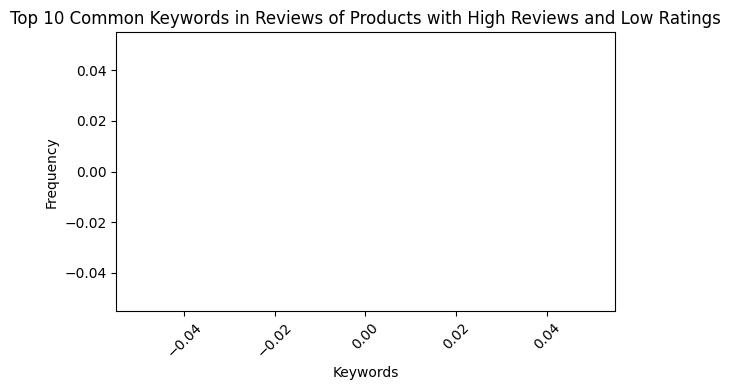

In [33]:
# Plot the top 10 common keywords
plt.figure(figsize=(6, 4))
plt.bar(list(common_keywords.keys())[:10], list(common_keywords.values())[:10], color='orange', width=0.7)
plt.xlabel("Keywords")
plt.ylabel("Frequency")
plt.title("Top 10 Common Keywords in Reviews of Products with High Reviews and Low Ratings")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 2.3 Top 5 Best Selling products
Next we will identify the top 5 best selling products of each category. As **best selling** we define those products with the highest number of reviews. We will also represent the features of these products.

In [34]:
top_best_selling_products = {} # Define a dictionary to keep the best selling products for every category

for category in categories:
    sorted_meta = dataframes['meta'][category].sort_values(by='rating_number', ascending=False)
    top_best_selling_products[category] = sorted_meta.head(5)

# Display the top 5 best-selling products for All_Beauty category
top_best_selling_products['All_Beauty']

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author,normalized_price,cleaned_title
193,All Beauty,Gel Nail Polish Starter Kit with 36W Nail Ligh...,3.9,1960,[],[],24.99,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': ['BUY BUY BUY YOU WILL LOVE IT!!', '...",Fashion Zone,[],"{""Material"": ""Acrylic"", ""Brand"": ""Fashion Zone...",B07PFH92HN,[],NaN,NaN,0.138872,gel nail polish starter kit 36w nail lightl na...
862,All Beauty,SnozzlePro Universal Hair Dryer Nozzle Adapter...,4.2,1953,['FITS MOST HAIR DRYERS: Made of 100% industri...,[],14.99,{'hi_res': ['https://m.media-amazon.com/images...,{'title': ['SnozzlePro vs Home Hack from BellC...,Snozzle Pro,[],"{""Product Dimensions"": ""2.5 x 2.5 x 2.5 inches...",B07X8Z9W22,[],NaN,NaN,0.083301,snozzlepro univers hair dryer nozzl adapt fit ...
568,All Beauty,"Vaultz Locking Makeup Artist Case, Black White...",4.3,1621,"['Perfect for a large makeup collection', 'Bui...","['At Vaultz, ""If it\'s Important to You, Lock ...",67.49,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': ['Vaultz Locking Makeup Artist Case,...",Vaultz,[],"{""Product Dimensions"": ""9.75 x 9.13 x 15.38 in...",B082245PK2,[],NaN,NaN,0.375049,vaultz lock makeup artist case black white str...
330,All Beauty,Biotique Bio Sandalwood Face and Body Sun Loti...,4.3,1578,[],[],21.00,{'hi_res': ['https://m.media-amazon.com/images...,{'title': ['GRWM to go to the pool Spring brea...,Biotique,[],"{""Sun Protection"": ""50 SPF"", ""Item Weight"": ""0...",B00G6KAQIE,[],NaN,NaN,0.116699,biotiqu bio sandalwood face bodi sun lotion sp...
783,All Beauty,eBoot 12 Pack Nylon Wig Caps for Women and Men...,4.3,1536,[],[],6.99,"{'hi_res': [None, None, None], 'large': ['http...","{'title': [], 'url': [], 'user_id': []}",EBOOT,[],"{""Material"": ""Synthetic"", ""Hair Type"": ""Curly""...",B0721K7229,[],NaN,NaN,0.038844,eboot 12 pack nylon wig cap woman men natur beig


Let's show these products with their feature list.

In [35]:
# Print the features of the top best-selling products
for category, products in top_best_selling_products.items():
    print(f"\nTop 5 Best-Selling Products in {category}:")
    for _, product in products.iterrows():
        print(f" - Product ID: {product['parent_asin']} (Number of Ratings: {product['rating_number']})")
        features = product['features'].split("', '")
        if features[0] == "[]":
            print("   > No features available")
        else:
            for feature in features:
                cleaned_feature = feature.replace("['", "").replace("']", "")
                print(f"   > Feature: {cleaned_feature}")
        print('\n')


Top 5 Best-Selling Products in All_Beauty:
 - Product ID: B07PFH92HN (Number of Ratings: 1960)
   > No features available


 - Product ID: B07X8Z9W22 (Number of Ratings: 1953)
   > Feature: FITS MOST HAIR DRYERS: Made of 100% industrial-strength silicone, SnozzlePro is flexible, durable, and fits most hair dryers with a nozzle diameter measuring 1.5" to 2.25". Please measure and confirm your hair dryer nozzle diameter BEFORE purchase.
   > Feature: FITS XTAVA BLACK ORCHID HAIR DIFFUSER: SnozzlePro’s super-tight fit on the Xtava Black Orchid Hair Diffuser is designed to grip and support the added weight of this short nozzle hair diffuser.', "PREVENTS CONCENTRATOR NOZZLE POP-OFFS: SnozzlePro's patented design keeps hair dryer concentrator nozzles securely attached for a perfect fit and protects hands from heat.", 'HOW TO USE - SnozzlePro comes with detailed HOW-TO-USE instructions. Please follow these instructions carefully before use. Diffuse on low to medium heat at low speed. Do not 

#### 2.4 Products Average Ratings per year
The last task is to analyze and visualize how average product rating has evolved within each category over the years. We will start by translating the **`timestamp`** column every category has, witch is represented as a **unix timestamp** in milliseconds, and receiving a more human read representation of it (dd-mm-yyyy).

In [36]:
import datetime

for category in categories:
    dataframes['review'][category]['timestamp_formatted'] = dataframes['review'][category]['timestamp'].apply(
        lambda x: datetime.datetime.fromtimestamp(x/1000)
    )

dataframes['review']['Gift_Cards'].tail()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,cleaned_title,cleaned_text,timestamp_formatted
995,5.0,She could buy whatever she wanted!,It was a perfect Christmas gift!,[],B01K8RJDEI,B00ADR2LV6,AHTFJNXOEO64MQHVOH3AGYF4HE7Q,1613427766696,0,True,could buy whatev want,wa perfect christma gift,2021-02-16 00:22:46.696
996,5.0,Great for frequent shoppers. Another super eas...,"What’s not to like? It’s quick, it’s easy, and...",[],B00IX1I3G6,B00IX1I3G6,AEYX2YVU5NMPPS5ZQASTWKDWPUJQ,1537034354280,1,True,great frequent shopper anoth super easi paymen...,like quick easi want buy someth cash balanc ri...,2018-09-15 20:59:14.280
997,5.0,AMAZING!,I stumbled on this while looking for a graduat...,[],B01N9GY4GF,B01B3DYSF0,AGWZ5RENSFTTMRPUJODLLF5QLIJQ,1591647031252,0,False,amaz,stumbl thi look graduat card glad graduat cap ...,2020-06-08 23:10:31.252
998,5.0,Cute package and easy to send,Wonderful gift idea,[],B0719C5P56,B0719C5P56,AGGAPGKPBGYIAIR3WK2ZIZYJ2OHA,1550340026239,0,True,cute packag easi send,wonder gift idea,2019-02-16 20:00:26.239
999,5.0,Nice way to plan and save,I like this feature because I can add to it mo...,[],B086KKT3RX,B086KKT3RX,AEWOYZ3H3FV72KC5HJ7MH7QCQ55A,1659046792988,0,True,nice way plan save,like thi featur becaus add monthli wheneverbr ...,2022-07-29 01:19:52.988


As we can see from the above dataframe, we have successfully created a new column with the formatted timestamp and we can easily work with it by extracting the year, the month, etc. We will now create a function that will return to us the average rating for every year.

In [37]:
# Get the average rating per year for each category
def get_average_rating_per_year(dataframes, categories):
    average_ratings_per_year = {}

    for category in categories:
        df = dataframes['review'][category]
        df['year'] = df['timestamp_formatted'].dt.year
        average_ratings = df.groupby('year')['rating'].mean().reset_index()
        average_ratings_per_year[category] = average_ratings

    return average_ratings_per_year

In [38]:
average_ratings_per_year = get_average_rating_per_year(dataframes, categories)

By executing the code above we have successfully extracted the average rating per year for the products of every category. Let's visualize this trend in a line plot.

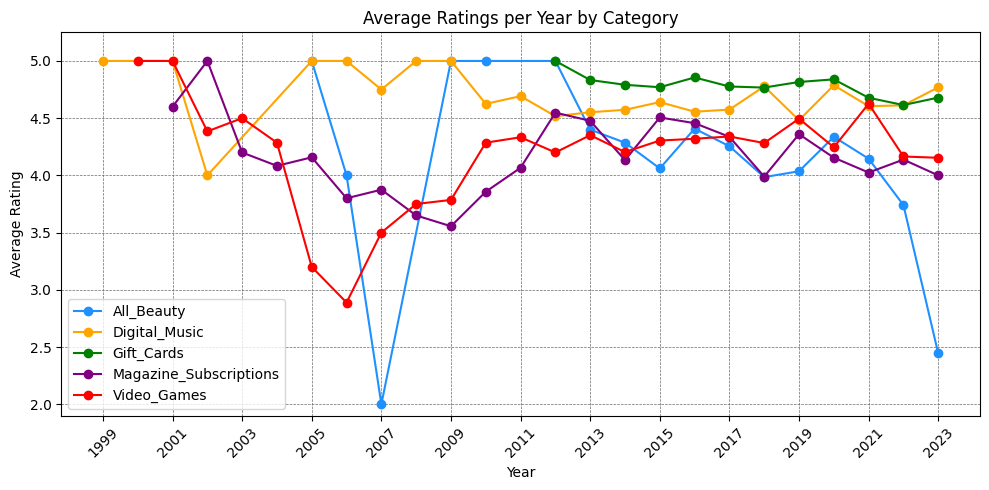

In [39]:
# Plot the average ratings per year for each category
colors = ['dodgerblue', 'orange', 'green', 'purple', 'red']
plt.figure(figsize=(10, 5))
for i, (category, average_ratings) in enumerate(average_ratings_per_year.items()):
    plt.plot(average_ratings['year'], average_ratings['rating'], color=colors[i], marker='o', label=category)

min_year = min(min(average_ratings['year']) for average_ratings in average_ratings_per_year.values())
max_year = max(max(average_ratings['year']) for average_ratings in average_ratings_per_year.values())

min_y = min(min(average_ratings['rating']) for average_ratings in average_ratings_per_year.values())
max_y = max(max(average_ratings['rating']) for average_ratings in average_ratings_per_year.values())

plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.title("Average Ratings per Year by Category")
plt.xticks(rotation=45)
plt.xticks(range(min_year, max_year+1, 2))
plt.ylim(min_y - 0.05*min_y, max_y + 0.05*max_y)
plt.grid(color='dimgray', linestyle='--', linewidth=0.5)

plt.legend()
plt.tight_layout()
plt.show()

As we can see from the above graph the earliest year production has started is 1997 and it is refered to the **Digital_Music** category. We will also define a function that will return to us the monthly average rating for a specific year.

In [40]:
def get_average_rating_for_year(dataframes, categories, year):
    """
    Returns the average rating for every month for a specific year across all categories.
    """
    average_ratings = {}

    for category in categories:
        df = dataframes['review'][category]
        df['year'] = df['timestamp_formatted'].dt.year
        df['month'] = df['timestamp_formatted'].dt.month

        # Filter the dataframe for the specified year
        df_year = df[df['year'] == year]

        # Calculate the average rating per month
        monthly_average = df_year.groupby('month')['rating'].mean().reset_index()
        average_ratings[category] = monthly_average

    return average_ratings

Below we test the function that we have just created for the year **2021** and we represent the results also in a line plot.

In [41]:
year = 2021
average_ratings_2021 = get_average_rating_for_year(dataframes, categories, year)

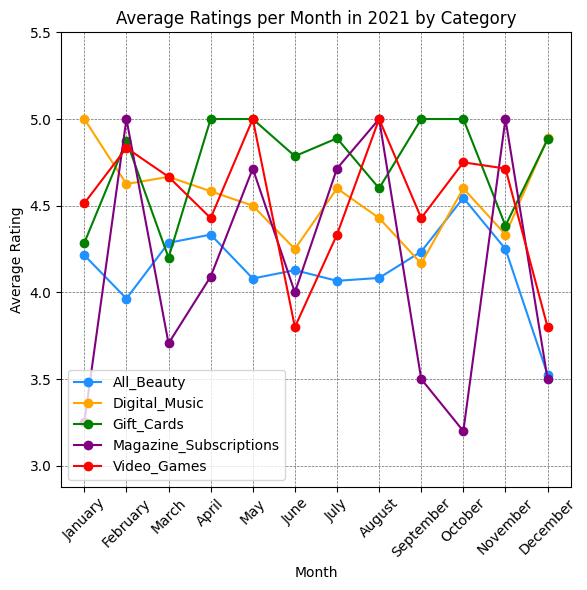

In [42]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Plot the average ratings per month for the specified year
colors = ['dodgerblue', 'orange', 'green', 'purple', 'red']
plt.figure(figsize=(6, 6))
for i, (category, average_ratings) in enumerate(average_ratings_2021.items()):
    plt.plot(average_ratings['month'], average_ratings['rating'], color=colors[i], marker='o', label=category)

min_month = min(min(avg['month']) for avg in average_ratings_2021.values() if not avg['month'].empty)
max_month = max(max(avg['month']) for avg in average_ratings_2021.values() if not avg['month'].empty)

min_y = min(min(avg['rating']) for avg in average_ratings_2021.values() if not avg['rating'].empty)
max_y = max(max(avg['rating']) for avg in average_ratings_2021.values() if not avg['rating'].empty)

plt.xlabel("Month")
plt.ylabel("Average Rating")
plt.title(f"Average Ratings per Month in {year} by Category")
plt.xticks(rotation=45)
plt.xticks(range(1, 13), months)
plt.ylim(min_y -0.1*min_y, max_y + 0.1*max_y)  # Adjust y-axis limits based on the dataset
plt.grid(color='dimgray', linestyle='--', linewidth=0.5)

plt.legend()
plt.tight_layout()
plt.show()

## Task 2: Feature Engineering with Sentiment Scores and Ratings
In the second task we had to choose between **two alternative methods** to combine text sentiment and review ratings to create a final sentiment score. Specifically the methods we were offered with are the following:
1. Alternative 1: **Weighted Combination of Text Sentiment and Rating**, and
2. Alternative 2: **Rating-Adjusted Sentiment**

In this work we chose to work with the first alternative, thinking that it will suit better to extract the final sentiment score.

### VADER Download
From the available options of extracting a base sentiment according to the review text, we prefer to work with **VADER**, a simple light weight sentiment classifier. This classifier takes as input a specific text, and outputs a score refering to its sentiment, specifically from **-1 (negative)** to **+1 (positive)**. Let's download the classifier.

In [43]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download the VADER classifier
nltk.download('vader_lexicon')
classifier = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/antonis/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Extracting Default Sentiment
After downloading the classifier for sentiment extraction from text, let's test it on our data and create a new column containing the sentiment score for each review.

In [44]:
for category in categories:
    print(f"Computing sentiment for {category}...")
    dataframes['review'][category]['base_sentiment'] = dataframes['review'][category]['cleaned_text'].apply(
        lambda x: classifier.polarity_scores(str(x))['compound']
    )

Computing sentiment for All_Beauty...
Computing sentiment for Digital_Music...
Computing sentiment for Gift_Cards...
Computing sentiment for Magazine_Subscriptions...
Computing sentiment for Video_Games...


### Normalizing the Rating
Before we proceed into using the rating to produce the final sentiment we need to normalize the rating column to the range of (0, 1). This will be usefull for us if we want to cobmine it with the base sentiment that we extracted using VADER classifier. The formula that normalizes the rating is shown below:
$$
    Normalized\_Rating = \frac{Rating - 1}{4}
$$
We will apply this formula to receive the normalized rating.

In [45]:
for category in categories:
    print(f"Normalizing rating for {category}...")
    dataframes['review'][category]['normalized_rating'] = dataframes['review'][category]['rating'].apply(
        lambda x: (x-1)/4
    )

Normalizing rating for All_Beauty...
Normalizing rating for Digital_Music...
Normalizing rating for Gift_Cards...
Normalizing rating for Magazine_Subscriptions...
Normalizing rating for Video_Games...


### Calculating the final Sentiment Score
Finally we will calculate the final sentiment score using the `base_sentiment` and `normalized_rating` columns that we have just computed. Specifically we will define two variables $w_1$ and $w_2$, that can be adjust to our preferences. This variables will be used in the final sentiment calculation as follows:
$$
    Final\_Sentiment\_Score = w_1 \times Base\_Sentiment + w_2 \times Normalized\_Rating
$$
Let's calculate it and store it

In [46]:
# Define the weights of the final sentiment calculation
w1 = 0.3
w2 = 1.0 - w1

# Calculate the final sentiment score for each category
for category in categories:
    print(f"Computing final sentiment for {category}...")
    current_df = dataframes['review'][category]
    current_df['final_sentiment'] = w1*current_df['base_sentiment'] + w1*current_df['normalized_rating']

Computing final sentiment for All_Beauty...
Computing final sentiment for Digital_Music...
Computing final sentiment for Gift_Cards...
Computing final sentiment for Magazine_Subscriptions...
Computing final sentiment for Video_Games...


Let's have a look at the modified `All_Beauty` dataframe and how it is so far after all the previous additions.

In [49]:
dataframes['review']['All_Beauty'].head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,cleaned_title,cleaned_text,timestamp_formatted,year,month,base_sentiment,normalized_rating,final_sentiment
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True,love scent overpow,thi spray realli nice smell realli good goe re...,2020-05-05 17:08:48.923,2020,5,0.8442,1.00,0.55326
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True,work great smell littl weird,thi product doe need wish wa odorless soft coc...,2020-05-04 21:10:55.070,2020,5,0.8625,0.75,0.48375
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True,ye,smell good feel great,2020-05-17 00:41:06.052,2020,5,0.7906,1.00,0.53718
3,1.0,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1643393630220,0,True,synthet feel,felt synthet,2022-01-28 20:13:50.220,2022,1,0.0000,0.00,0.00000
4,5.0,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1609322563534,0,True,NaN,love,2020-12-30 12:02:43.534,2020,12,0.6369,1.00,0.49107


As we can see the final sentiment score has been successfully computed and stored inside the `final_sentiment` column.